# Time Series Analysis - ARIMA Model

In this project I used time series analysis to forcast Google stock prices. In this project I first explored the data, then made sure it was good to go for running an ARIMA model on, and then ran the model.

Table of Contents:
    1. Data Exploration
    2. Dickey-Fuller Test
    3. Decompositions
    4. Differencing 
    5. Training and Testing ARIMA model

In [424]:
#Importing Libraries

#Matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

#Statsmodel and sklearn for modeling and metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import numpy as np
import pandas as pd
from dateutil.parser import parse

import warnings
warnings.filterwarnings("ignore")

## Data Exploration

In [425]:
#Reading in dataset 
df = pd.read_csv('google.csv', parse_dates = ["Date"])
df.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
1,2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2,2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
3,2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
4,2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [426]:
#Cleaning out columns that are not needed
print("There are ", len(df[df["High"].isnull()]), \
      "null values in the 'High' column")


df = df[["Date","High"]]
df.head()

There are  0 null values in the 'High' column


,Date,High
0,2012-01-03,332.83
1,2012-01-04,333.87
2,2012-01-05,330.75
3,2012-01-06,328.77
4,2012-01-09,322.29


#### Plotting Raw Time Series Data

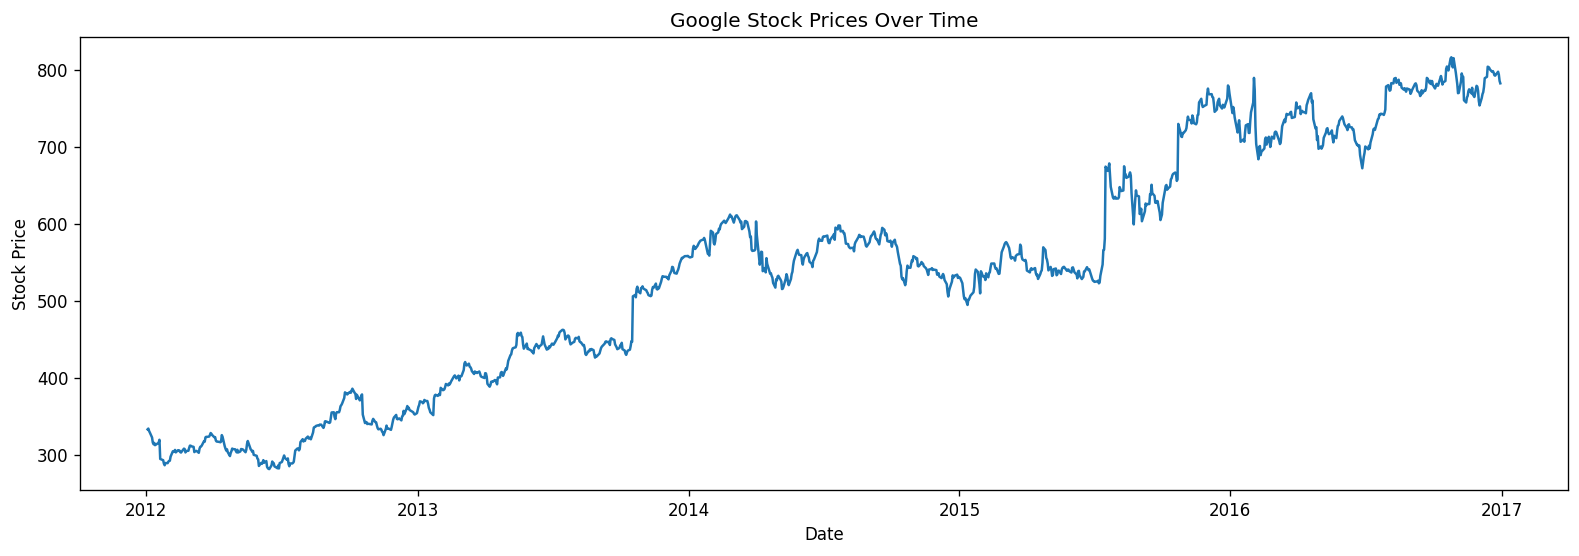

In [427]:
#Plotting raw time series data
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Stock Price'):
    plt.figure(figsize=(16,5))
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(df, x=df["Date"], y=df["High"], \
        title='Google Stock Prices Over Time')  

The graph above this the raw time series data plotted. The x-axis is the date and the y-axis is the stock price.
When analyzing time series data you must consider the following:
1. What is the trend:
    Just By looking at the graph we can see that over time the stock price increases so we say that this has an upward trend
2. Is there seasonality: 
    Since this graph spans over many years and has several ups and downs it is hard to determine if there is a repeating pattern 
3. Is there any randomness:
    Even this is hard to tell just by looking at this graph on these axes but around 2014 and 2016 there seems to be higher highs.

#### Plotting Each Year on a Seperate Line (2012 - 2016)

2012 : vivid purple
2013 : bright lavender
2014 : sapphire
2015 : dark fuchsia
2016 : dusky pink


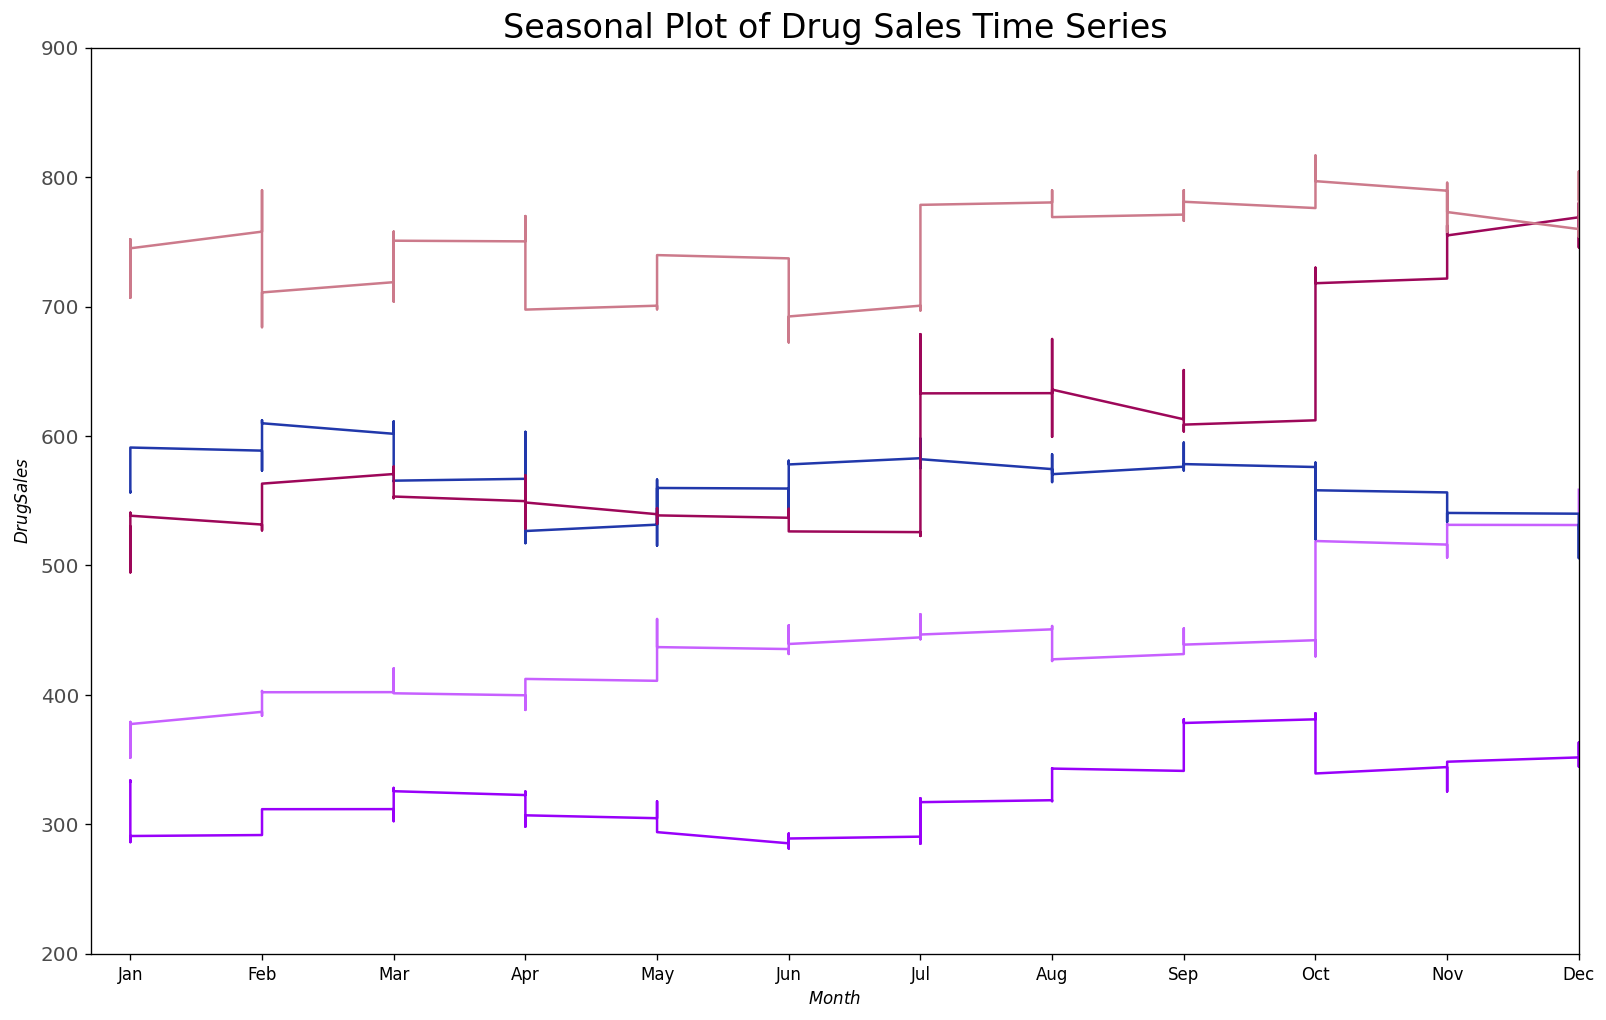

In [428]:
#Get year and month for each datapoint
df['year'] = [d.year for d in df["Date"]]
df['month'] = [d.strftime('%b') for d in df["Date"]]
years = df['year'].unique()

#Colors for the different years
mycolors = ['xkcd:vivid purple', 'xkcd:bright lavender', 'xkcd:sapphire', \
            'xkcd:dark fuchsia', 'xkcd:dusky pink']

#Loop through each unique year and plot data from that year
plt.figure(figsize=(16,10))
for i, y in enumerate(years):
    if i >= 0:   
        print(y, ":", mycolors[i][5:])
        plt.plot('month', 'High', data=df.loc[df["year"]==y, :], color=mycolors[i], label=y)

# Fix Graph
plt.gca().set(xlim=(-0.3, 11), ylim=(200, 900), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

In this graph we can see each years' trend on the same axes. Each year appears to be fairly stationary with some ups and downs but no obvious upward or downward trend. 2015 is the odd one out that has a very clear upward trend. And overall we can see that each year has, on average, higher stock prices that the one before it.

*Side Note: I'm curious to see if data from 2008 would resemble a "randomness" in the dataset

#### Augmented Dickey-Fuller Test for Stationary
Stationary is a term to describe a time series data set that has similar distributions over all windows of time. There is strong and weak stationaries. Strong stationary means that the for windows of the same width the data has the same distribution. Weak stationary means that for those same windows that the mean, variance, and autocorrelation are the same. 

The Dickey-Fuller Test is a way to measure if the data set is stationary. 

In [429]:
df = pd.read_csv('google.csv', parse_dates = ["Date"], index_col = "Date")
X = df["High"].to_list()

result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.685244
p-value: 0.850535
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


From the values outputed by the Dickey-Fuller test we can see that this data set is not stationary. One way to see that is the p-value of .85 is larger than the standard .05 significance level so we fail to reject the null hypothesis, which is that there is a unit root. (Having a unit root means that the data set is not stationary.)
Another way to see this is that the ADF statistice is -.68 which is larger than the 5% critical value of -2.864 so we also fail to reject the null in this situation too. 

Keeping this in mind we have to make the data set stationary before we fit it to a model and make predictions. 

#### Decompose Time Series (multiplicative & Additive)

Time series data can be thought of being composed of the trend + seasonality + error.

We have either a multiplicative decomposition(trend * seasonality * error.) or an additive decomposition (trend + seasonality + error). 

Trend is just the overal direction of the data, either constant, upward, or downward. Seasonality is the repeating cyclical patterns in the data. And error is the unexplained variance.

Decomposition is another way to explore the dataset as it breaks the data set into those parts, isolates each, and graphs it. 

In order to find the trend and seasonality we use LOESS Regression (locally estimated scatterplot smoothing). You do this by taking small sections of the data and using it to gather a weighted linear regression of the points nearby to estimate the value at that time. This will smooth out to the trend line.

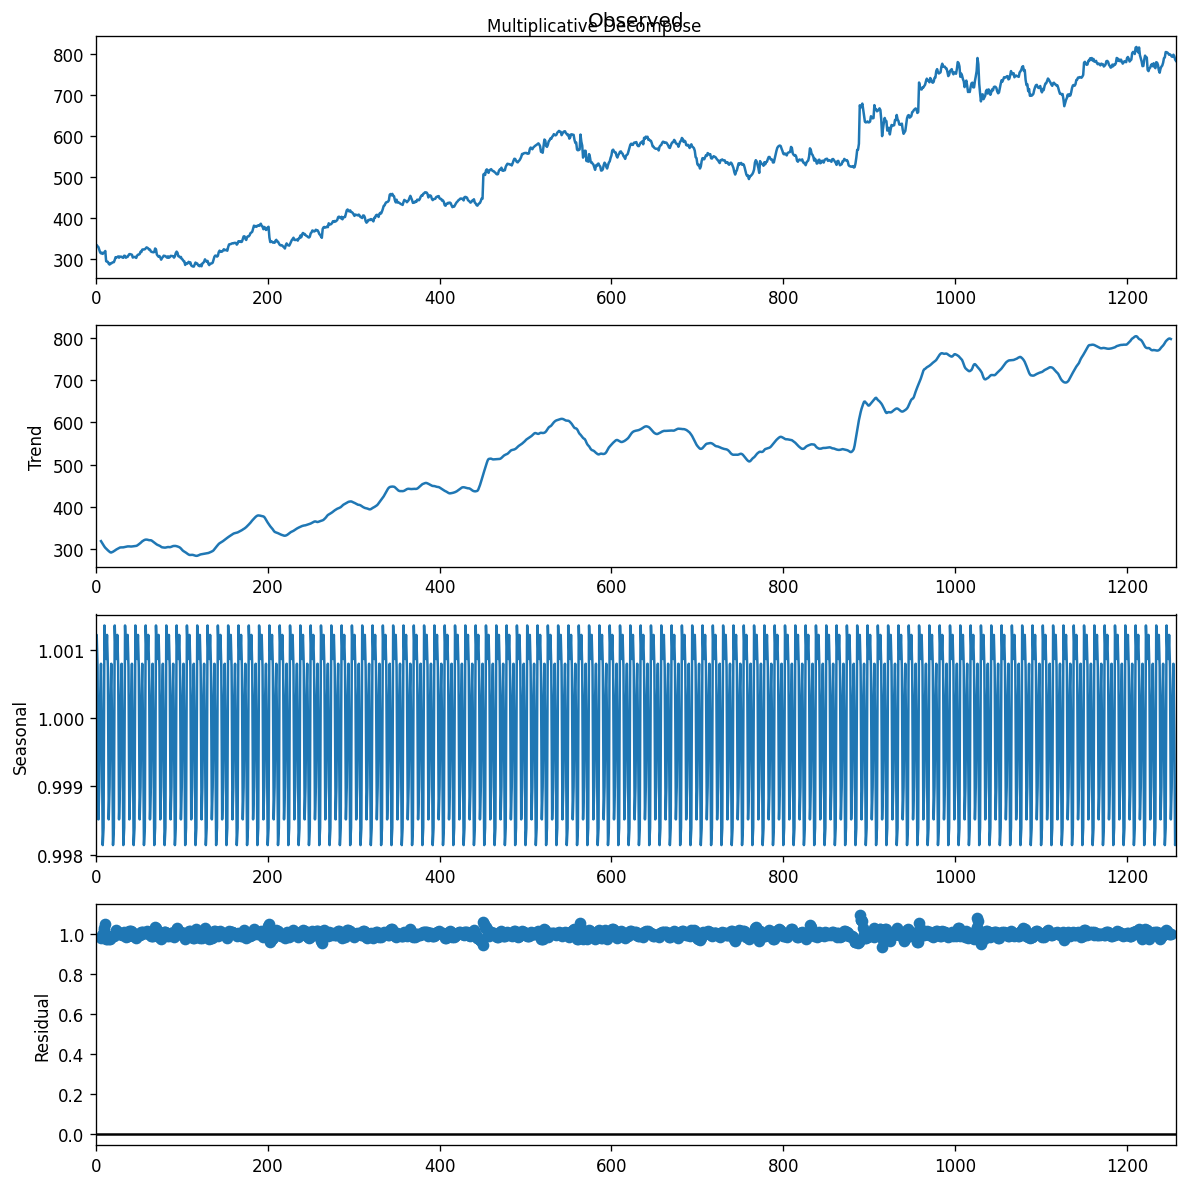

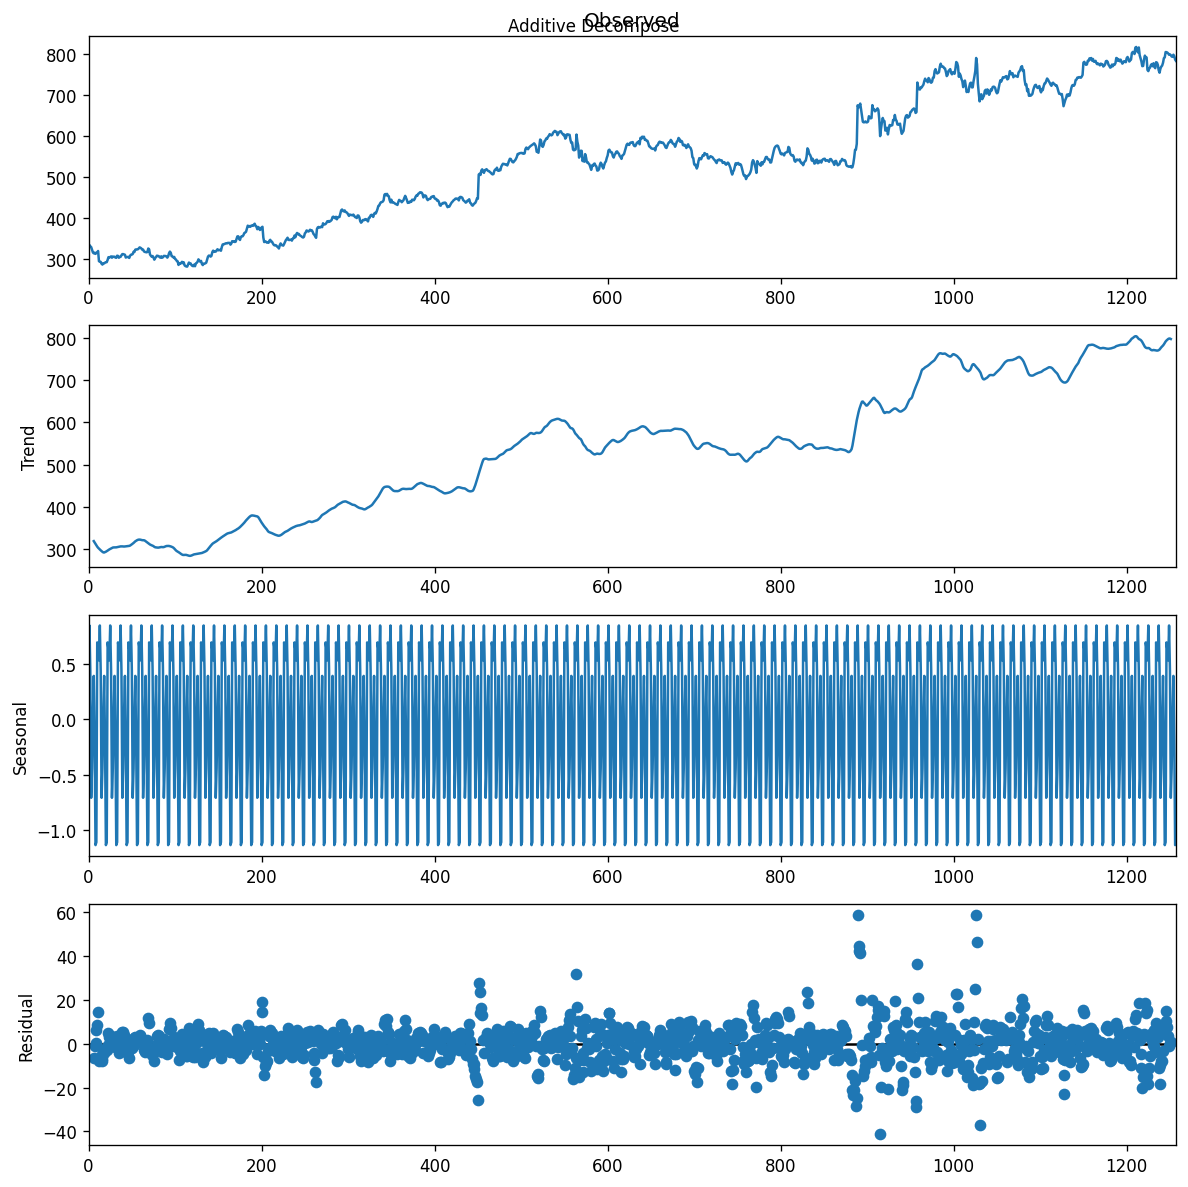

In [436]:
df = pd.read_csv('google.csv', parse_dates = ["Date"], index_col = "Date")

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df["High"].to_list(), model='multiplicative', period = 12)

# Additive Decomposition
result_add = seasonal_decompose(df['High'].to_list(), model='additive', period = 12)

#Plot Each Type of Decomposition 
plt_mul = result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)
plt_add = result_add.plot().suptitle('Additive Decompose', fontsize=10)

In the graphs above we can see that there is a very clear seasonality happening. And that there is an obvious upward trend.

## Data Preparation
#### Decomposition and Seasonal Differencing to Make Data Stationary

In order to run any forcasting model (in our case ARIMA) we need to make the data stationary. The first graph beloe shows another way to perform decomposition. It is by using a rolling average. It takes the average of the 75 nearest points and plots that. We can see the trend line in that graph as well.

The second graph is where we perform seasonal differencing to make the data stationary. It subtracts the 60th point in the past from the current point. It is 60 days back because for our data that is one season in the past. This levels out data out to be able to run an ARIMA model.

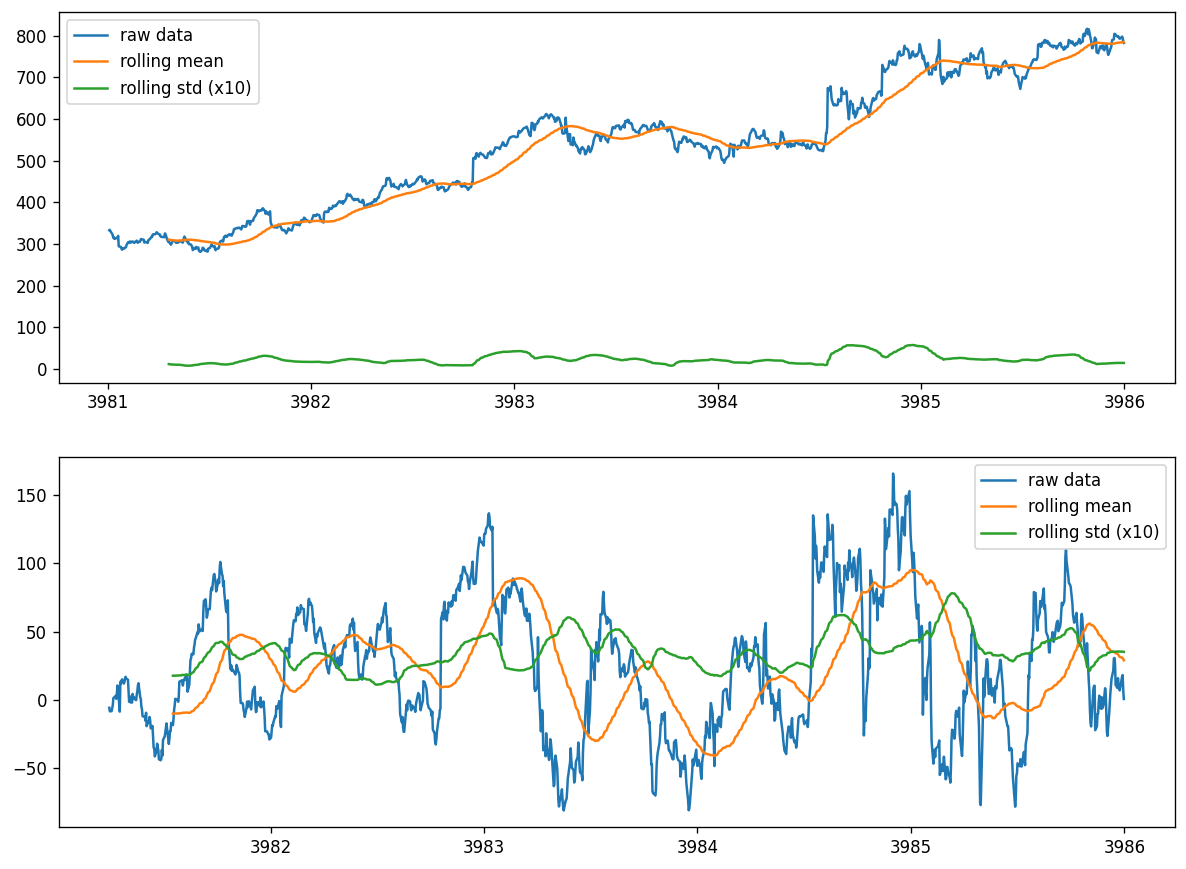

In [437]:
#load a fresh copy of data
df = pd.read_csv('google.csv', parse_dates = ["Date"], index_col = "Date")
df = df[["High"]]

# TODO
fig, ax = plt.subplots(2,figsize=(12, 9))
ax[0].plot(df.index, df["High"], label='raw data')     
ax[0].plot(df["High"].rolling(window=75).mean(), label="rolling mean");
ax[0].plot(df["High"].rolling(window=75).std(), label="rolling std (x10)");
leg = ax[0].legend()

#TODO
df['high_diff'] = df['High'] - df['High'].shift(60)
ax[1].plot(df.index, df["high_diff"], label='raw data')     
ax[1].plot(df["high_diff"].rolling(window=75).mean(), label="rolling mean");
ax[1].plot(df["high_diff"].rolling(window=75).std(), label="rolling std (x10)");
leg = ax[1].legend()

df = df.dropna()

# Training and Testing ARIMA Model
The ARIMA model is a time series forcasting model that leverages auto-regressive models, moving average models, and differencing. 

In [435]:
#split data into train and test sets
train, test = df[0:694], df[694:len(df)]
train.head()

,High,high_diff
Date,,
2012-03-29,327.07,-5.76
2012-03-30,325.52,-8.35
2012-04-02,322.54,-8.21
2012-04-03,322.77,-6.00
2012-04-04,318.31,-3.98


#### Training the ARIMA Model

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  693
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2414.465
Method:                       css-mle   S.D. of innovations              7.886
Date:                Sat, 15 Aug 2020   AIC                           4842.930
Time:                        17:19:12   BIC                           4874.717
Sample:                             1   HQIC                          4855.223
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0617      0.335     -0.184      0.854      -0.717       0.594
ar.L1.D.y      0.0865      0.038      2.283      0.022       0.012       0.161
ar.L2.D.y      0.0189      0.038      0.498      0.6

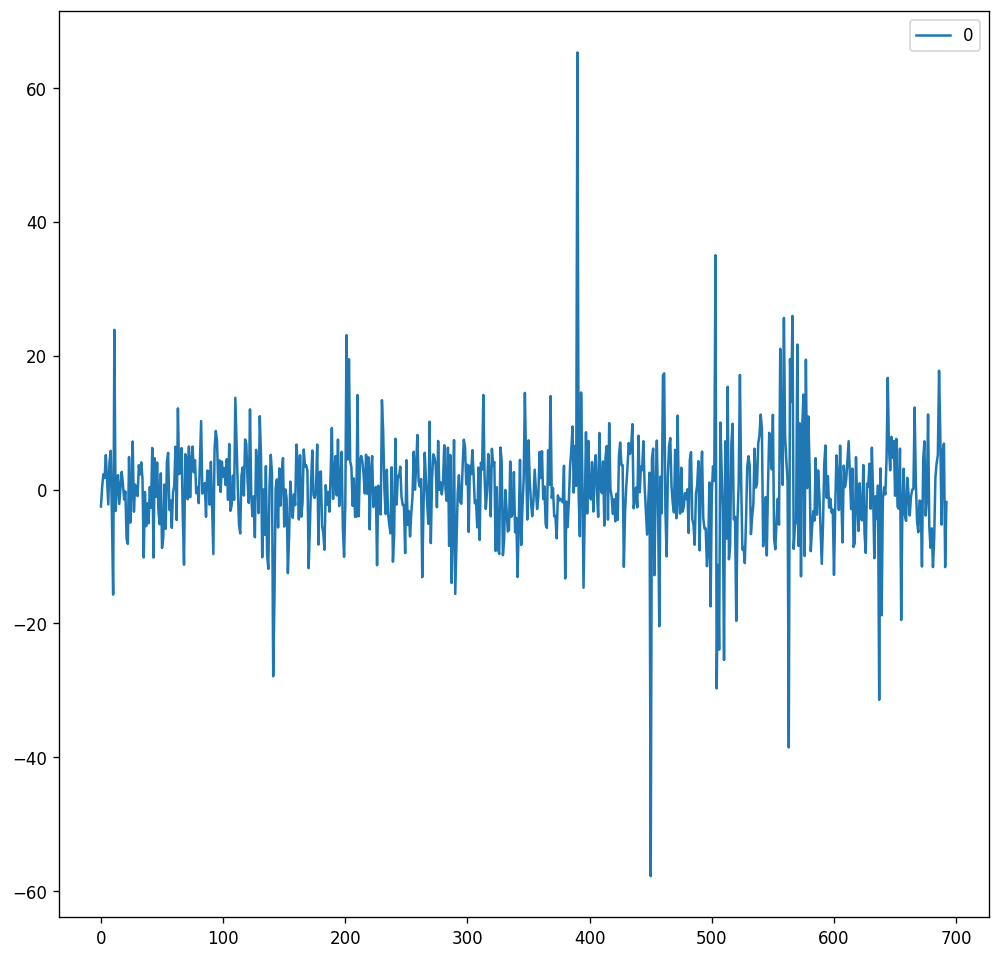

In [443]:
#Fit the ARIMA model
model = ARIMA(train["high_diff"].to_list(), order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

#plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

#### Testing ARIMA Model

In [444]:
history = [x for x in train["high_diff"]]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test["High"][t]
    history.append(obs)

#### Finding MSE and Plotting Results

Test MSE: 775.156


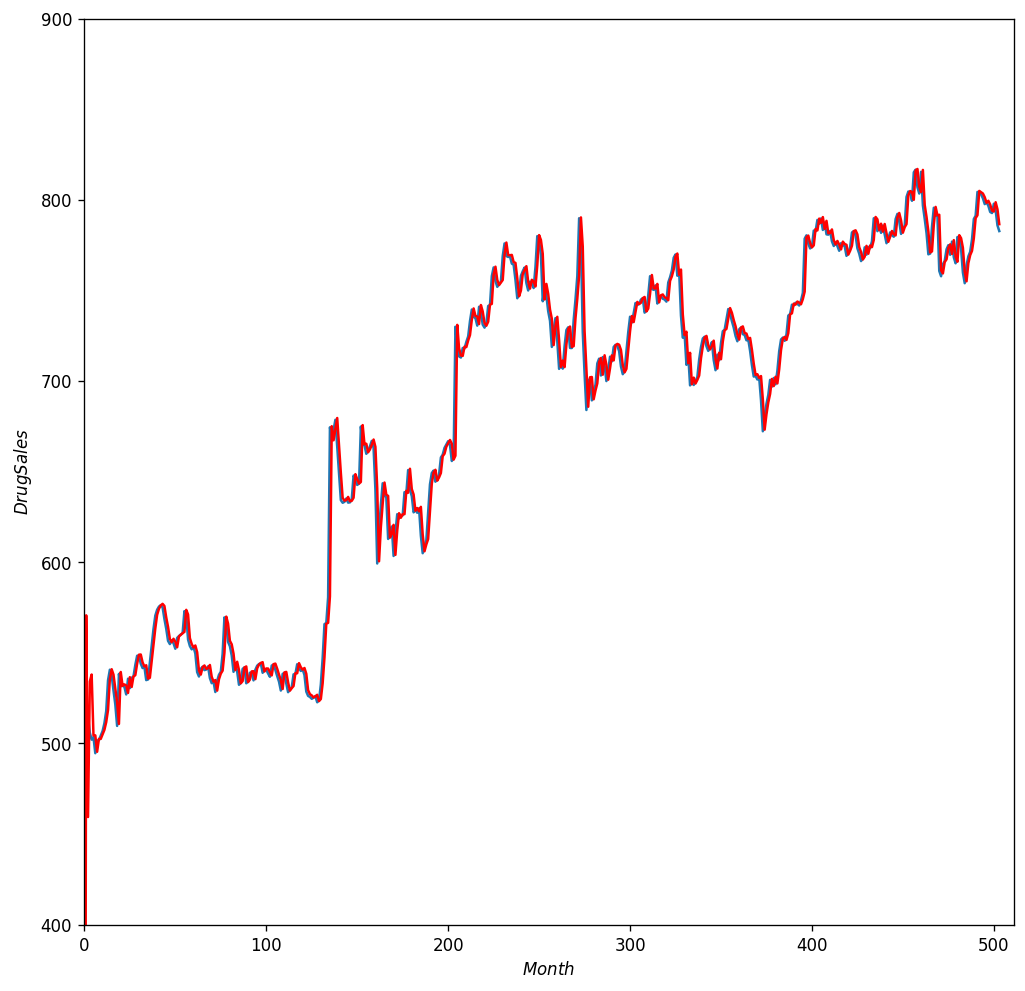

In [445]:
error = mean_squared_error(test["High"], predictions)
print('Test MSE: %.3f' % error)

x = [i for i in range(len(test))]
plt.gca().set(xlim=(-0.3, 511), ylim=(400, 900), ylabel='$Drug Sales$', xlabel='$Month$')
plt.plot(x, test["High"])
plt.plot(x, predictions, color='red')
pyplot.show()

We can see that the red line is very close to the blue line and that the mean squared error is not that large. This model worked pretty well.